In [1]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_02_5_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68a9e76e-34d5-45fc-9d39-d20c2a52eaa1.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c02c6c-8426-4a07-ab77-7217078a6e6a.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c13574-a0dc-49e3-8004-923f0b2d278f.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c36cca-65a3-451b-9e47-4fda245588bc.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c51c0c-777a-4e8a-9543-7f6a6101e6c9.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68c87e83-8ab6-412a-b0bb-25b4e1d1e678.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68cad8ac-5e8e-45d8-ab2f-8a119580087d.png  
  inflating: content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train/normal/68d6f135

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import *
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Train', transform=train_transforms)
validation_data = datasets.ImageFolder('/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Validation', transform=train_transforms)
test_data = datasets.ImageFolder('/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True,num_workers=5)

validationloader = torch.utils.data.DataLoader(validation_data, batch_size=200, shuffle=True,num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Training images with augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


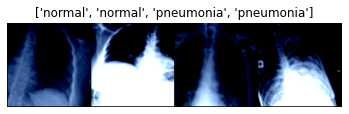

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


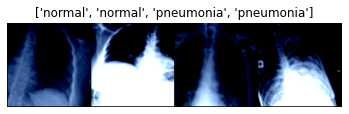

In [5]:
# Creating function to show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# creating grid to display batch of images 
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
print('Training images with augmentation')
inputs, classes = next(iter(trainloader))
# displaying training images
show_databatch(inputs[:4], classes[:4])

# Get a batch of testing data
#print('Testing images without augmentation')
#inputs, classes = next(iter(testloader))
# displaying testing images
show_databatch(inputs[:4], classes[:4])

In [0]:
# creating a function to train training data in differement experiments using different structures and models 
def train_model(model, epochs, training_data, validation_data, optimizer, criterion, filename):
    # Converting data to GPU processable form if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    # creating arrays to store stats
    training_accuracy = []
    validation_accuracy = []
    training_loss = []
    validation_loss = []
    nb_digits = 3 
    # Traing data
    for epoch in range(epochs):  # loop over the dataset multiple times
        # to show progress 
        pbar = tqdm(enumerate(training_data))
        
        # getting each batch for training 
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            label_onehot = torch.FloatTensor(len(labels), nb_digits)
            label_onehot=label_onehot.to(device)
            label_onehot.zero_()
            label_onehot.scatter_(1, labels.data.unsqueeze(dim=1), 1)            
            # zero the parameter gradients
            optimizer.zero_grad()
            # feedforward
            outputs = model(inputs)
            # computing loss              
            loss = criterion(outputs, label_onehot)
            # backprpagation   
            loss.backward() 
            # updating weights                    
            optimizer.step()                    

            # displaying progess
            pbar.set_description(
                'Training Epoch: {},({:.0f}%)'.format(
                    epoch+1, int((100. * i / len(training_data))+1)))
        
        # Displaying stats for current epoch
        # calculating stats on training data for current epoch
        print('\nFor training data')
        train_loss,train_accu,train_precision,train_recall,train_f1,train_confusion = scores(training_data,model)

        # calculating stats on validation data for current epoch
        print('\nFor validation data')
        valid_loss,valid_accu,valid_precision,valid_recall,valid_f1,valid_confusion = scores(validation_data,model)
        
        # storing stats in arrays to plot curves
        training_accuracy.append(train_accu)
        validation_accuracy.append(valid_accu)
        training_loss.append(train_loss)
        validation_loss.append(valid_loss)
        print("\nTraining Accuracy = ",train_accu, '\nTraining Loss = ',train_loss, "\nValidation Accuracy = ",valid_accu, '\nValidation Loss = ',valid_loss,"\n")  
    
    # displaing final epoch's stats on training data
    print('Final Stats:\n')
    train_stats = pd.DataFrame([train_loss,train_accu,train_precision,train_recall,train_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Training Scores']).T
    print(train_stats)
    print()
    
    # displaing final epoch's stats on validaiton data
    valid_stats = pd.DataFrame([valid_loss,valid_accu,valid_precision,valid_recall,valid_f1],['Loss','Accuracy','Precision','Recall','F1_Score'],['Validation Scores']).T
    print(valid_stats)
    print()

    # displaying confusion matrix for training data
    sns.heatmap(train_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
    plt.title('Confusion Matrix for Training Data')
    plt.xlim(reversed(plt.xlim()))
    plt.show()
    print()

    # displaying confusion matrix for validation data
    sns.heatmap(valid_confusion, annot=True, fmt='g', cbar=False, cmap=['Pink','Grey','Red','Green'])
    plt.title('Confusion Matrix for Validation Data')
    plt.xlim(reversed(plt.xlim()))
    plt.show()
    print()

    # plotting entropy loss on training and validation data
    plt.title('Loss')
    plt.plot(range(epochs),training_loss, label= 'Training Data')
    plt.plot(range(epochs),validation_loss,label='Validation Data')
    plt.ylim(0,1)
    plt.legend()
    plt.show()  
    print()
        
    # plotting accuracy for training and validation data
    plt.title('Accuracy')
    plt.plot(range(epochs),training_accuracy,label= 'Training Data')
    plt.plot(range(epochs),validation_accuracy,label= 'Validation Data')
    plt.ylim(70,100)
    plt.legend()
    plt.show()
    
    # saving the model
    torch.save(model.state_dict(), filename)

In [0]:
def scores(dataset,model):
    correct = 0
    total = 0
    loss = 0
    predicted = []
    true_labels = []
    nb_digits = 3 
    # getting prediction made by the model     
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        # to display progess
        pbar = tqdm(enumerate(dataset))
        # getting each batch 
        for i,data in pbar:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            val_label_onehot=torch.FloatTensor(len(labels), nb_digits)
            val_label_onehot=val_label_onehot.to(device)
            val_label_onehot.zero_()
            val_label_onehot.scatter_(1,labels.data.unsqueeze(dim=1),1.0)  
            # Feedforward
            outputs = model(images)
            # calculating predictions by the model
            _, pred = torch.max(outputs.data, 1)
            # storing predictions in a list 
            predicted.extend(pred.tolist())
            # storing actutal labels in list
            true_labels.extend(labels.tolist())            
            # calculating loss 
            loss += criterion(outputs, val_label_onehot).item()

            # displaying progress
            pbar.set_description(
                'Calculating Accuracy and Loss: ({:.0f}%)'.format(
                    int((100. * i / len(dataset))+1)))
    
    # calculating loss on whole data
    total_loss = loss/len(dataset)
    # calculating accurate predictions of model on whole data
    accuracy = accuracy_score(true_labels,predicted)*100
    # calculating recall
    recall = recall_score(true_labels,predicted,average='micro')*100
    # calculating precision
    precision = precision_score(true_labels,predicted,average='micro')*100
    # calculating F1_Score
    f1 = f1_score(true_labels,predicted,average='micro')*100
    # making confusion matrix
    confusion = pd.DataFrame(confusion_matrix(true_labels,predicted),['covid-19','pneumonia','Normal'],['covid-19','pneumonia','Normal'])

    return total_loss,accuracy,precision,recall,f1,confusion

In [0]:
def GenerateCSV(dataset,model):
    correct = 0
    total = 0
    loss = 0
    predicted = []
    true_labels = []
    nb_digits = 3 
    f = open("WithOutFocalResNet", "w")
    # getting prediction made by the model 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        # to display progess
        # = tqdm(enumerate(dataset))
        # getting each batch 
        for i, data in enumerate(dataset, 0):
            images, labels = data            
            images, labels = images.to(device), labels.to(device)
            val_label_onehot=torch.FloatTensor(len(labels), nb_digits)
            val_label_onehot=val_label_onehot.to(device)
            val_label_onehot.zero_()
            val_label_onehot.scatter_(1,labels.data.unsqueeze(dim=1),1.0)  
            # Feedforward
            outputs = model(images)            
            #print(outputs)
            # calculating predictions by the model  
            test = torch.sigmoid(outputs)          
            #_, pred = torch.sigmoid(outputs)
            # storing predictions in a list 
            #print(test)
            #predicted.extend(test.tolist())            
            imageName = dataset.dataset.samples[i][0].split("/")[-1]     
            #print("imageName",type(imageName))
            listof = test.tolist()  
            #withname = listof.append(imageName)   
            #listof += [imageName]   
            #print(listof)
            if(listof[0][0]>0.5):
              listof[0][0] = 1
            else:
              listof[0][0] = 0

            if(listof[0][2]>0.5):
              listof[0][2] = 1
            else:
              listof[0][2] = 0

            if(listof[0][1]>0.5):
              listof[0][1] = 1
            else:
              listof[0][1] = 0
            f.write("{},{},{},{}\n".format(imageName,listof[0][0],listof[0][2],listof[0][1] ))
            #predicted.extend(.insert(0,imageName))
            # storing actutal labels in list
            #true_labels.extend(labels.tolist())            
            # calculating loss 

            #loss += criterion(outputs, val_label_onehot).item()

            # displaying progress
            #pbar.set_description(
            #    'Calculating Accuracy and Loss: ({:.0f}%)'.format(
            #        int((100. * i / len(dataset))+1)))
    
    # calculating loss on whole data
    #total_loss = loss/len(dataset)
    print(predicted);
    # calculating accurate predictions of model on whole data
    #accuracy = accuracy_score(true_labels,predicted)*100
    # calculating recall
    #recall = recall_score(true_labels,predicted,average='micro')*100
    # calculating precision
    #precision = precision_score(true_labels,predicted,average='micro')*100
    # calculating F1_Score
    #f1 = f1_score(true_labels,predicted,average='micro')*100
    # making confusion matrix
    #confusion = pd.DataFrame(confusion_matrix(true_labels,predicted),['covid-19','pneumonia','Normal'],['covid-19','pneumonia','Normal'])
    f.close()
    return 1

In [0]:
res18 = models.resnet18(pretrained=True)
features = []
num_features = 87*10+100
num_classes = 3
features.extend([nn.Linear(512, num_features)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, num_classes)])
res18.fc = nn.Sequential(*features)

In [0]:
for param in res18.parameters():
    param.requires_grad = True

In [11]:
print('Following Parameters/Features are freezed:')
for name, param in res18.named_parameters():
    if param.requires_grad==False:
        print(name)
print('\nFollowing Parameters/Features will be trained:')
for name, param in res18.named_parameters():
    if param.requires_grad==True:
        print(name)

Following Parameters/Features are freezed:

Following Parameters/Features will be trained:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
laye

In [0]:
#torch.cuda.empty_cache()



0it [00:00, ?it/s]

Training Epoch: 1,(1%): : 0it [00:19, ?it/s]

Training Epoch: 1,(1%): : 1it [00:19, 19.07s/it]

Training Epoch: 1,(4%): : 1it [00:20, 19.07s/it]

Training Epoch: 1,(4%): : 2it [00:20, 13.90s/it]

Training Epoch: 1,(7%): : 2it [00:21, 13.90s/it]

Training Epoch: 1,(7%): : 3it [00:21,  9.84s/it]

Training Epoch: 1,(10%): : 3it [00:21,  9.84s/it]

Training Epoch: 1,(10%): : 4it [00:21,  7.01s/it]

Training Epoch: 1,(13%): : 4it [00:22,  7.01s/it]

Training Epoch: 1,(13%): : 5it [00:22,  5.02s/it]

Training Epoch: 1,(17%): : 5it [00:37,  5.02s/it]

Training Epoch: 1,(17%): : 6it [00:37,  8.10s/it]

Training Epoch: 1,(20%): : 6it [00:40,  8.10s/it]

Training Epoch: 1,(20%): : 7it [00:40,  6.48s/it]

Training Epoch: 1,(23%): : 7it [00:40,  6.48s/it]

Training Epoch: 1,(23%): : 8it [00:40,  4.65s/it]

Training Epoch: 1,(26%): : 8it [00:40,  4.65s/it]

Training Epoch: 1,(26%): : 9it [00:40,  3.37s/it]

Training Epoch: 1,(30%): : 9it [00:41,  3.37s/it]

Training Epoch: 1,(


For training data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:19, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:19, 19.66s/it]

Calculating Accuracy and Loss: (4%): : 1it [00:19, 19.66s/it]

Calculating Accuracy and Loss: (4%): : 2it [00:19, 13.82s/it]

Calculating Accuracy and Loss: (7%): : 2it [00:20, 13.82s/it]

Calculating Accuracy and Loss: (7%): : 3it [00:20,  9.75s/it]

Calculating Accuracy and Loss: (10%): : 3it [00:20,  9.75s/it]

Calculating Accuracy and Loss: (10%): : 4it [00:20,  6.89s/it]

Calculating Accuracy and Loss: (13%): : 4it [00:20,  6.89s/it]

Calculating Accuracy and Loss: (13%): : 5it [00:20,  4.92s/it]

Calculating Accuracy and Loss: (17%): : 5it [00:39,  4.92s/it]

Calculating Accuracy and Loss: (17%): : 6it [00:39,  9.11s/it]

Calculating Accuracy and Loss: (20%): : 6it [00:39,  9.11s/it]

Calculating Accuracy and Loss: (20%): : 7it [00:39,  6.47s/it]

Calculating Accuracy and Loss: (23%): : 7it [00:40,  6.47s/it]

Calculating Accuracy and Lo


For validation data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:11, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:11, 11.68s/it]

Calculating Accuracy and Loss: (26%): : 1it [00:11, 11.68s/it]

Calculating Accuracy and Loss: (26%): : 2it [00:11,  8.22s/it]

Calculating Accuracy and Loss: (51%): : 2it [00:12,  8.22s/it]

Calculating Accuracy and Loss: (51%): : 3it [00:12,  5.82s/it]

Calculating Accuracy and Loss: (76%): : 4it [00:12,  3.04s/it]


Training Accuracy =  64.51612903225806 
Training Loss =  0.457024751170989 
Validation Accuracy =  63.69426751592356 
Validation Loss =  0.4895198568701744 






0it [00:00, ?it/s]

Training Epoch: 2,(1%): : 0it [00:20, ?it/s]

Training Epoch: 2,(1%): : 1it [00:20, 20.01s/it]

Training Epoch: 2,(4%): : 1it [00:20, 20.01s/it]

Training Epoch: 2,(4%): : 2it [00:20, 14.12s/it]

Training Epoch: 2,(7%): : 2it [00:20, 14.12s/it]

Training Epoch: 2,(7%): : 3it [00:20, 10.00s/it]

Training Epoch: 2,(10%): : 3it [00:21, 10.00s/it]

Training Epoch: 2,(10%): : 4it [00:21,  7.12s/it]

Training Epoch: 2,(13%): : 4it [00:21,  7.12s/it]

Training Epoch: 2,(13%): : 5it [00:21,  5.11s/it]

Training Epoch: 2,(17%): : 5it [00:38,  5.11s/it]

Training Epoch: 2,(17%): : 6it [00:38,  8.52s/it]

Training Epoch: 2,(20%): : 6it [00:38,  8.52s/it]

Training Epoch: 2,(20%): : 7it [00:38,  6.08s/it]

Training Epoch: 2,(23%): : 7it [00:38,  6.08s/it]

Training Epoch: 2,(23%): : 8it [00:38,  4.38s/it]

Training Epoch: 2,(26%): : 8it [00:41,  4.38s/it]

Training Epoch: 2,(26%): : 9it [00:41,  3.84s/it]

Training Epoch: 2,(30%): : 9it [00:41,  3.84s/it]

Training Epoch: 2,


For training data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:19, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:19, 19.12s/it]

Calculating Accuracy and Loss: (4%): : 1it [00:20, 19.12s/it]

Calculating Accuracy and Loss: (4%): : 2it [00:20, 13.76s/it]

Calculating Accuracy and Loss: (7%): : 2it [00:20, 13.76s/it]

Calculating Accuracy and Loss: (7%): : 3it [00:20,  9.73s/it]

Calculating Accuracy and Loss: (10%): : 3it [00:20,  9.73s/it]

Calculating Accuracy and Loss: (10%): : 4it [00:20,  6.87s/it]

Calculating Accuracy and Loss: (13%): : 4it [00:21,  6.87s/it]

Calculating Accuracy and Loss: (13%): : 5it [00:21,  4.90s/it]

Calculating Accuracy and Loss: (17%): : 5it [00:39,  4.90s/it]

Calculating Accuracy and Loss: (17%): : 6it [00:39,  8.83s/it]

Calculating Accuracy and Loss: (20%): : 6it [00:39,  8.83s/it]

Calculating Accuracy and Loss: (20%): : 7it [00:39,  6.29s/it]

Calculating Accuracy and Loss: (23%): : 7it [00:39,  6.29s/it]

Calculating Accuracy and Lo


For validation data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:10, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:10, 10.46s/it]

Calculating Accuracy and Loss: (26%): : 1it [00:11, 10.46s/it]

Calculating Accuracy and Loss: (26%): : 2it [00:11,  7.66s/it]

Calculating Accuracy and Loss: (51%): : 2it [00:11,  7.66s/it]

Calculating Accuracy and Loss: (51%): : 3it [00:11,  5.41s/it]

Calculating Accuracy and Loss: (76%): : 4it [00:11,  2.96s/it]


Training Accuracy =  65.69354838709678 
Training Loss =  0.4219060453676408 
Validation Accuracy =  65.92356687898089 
Validation Loss =  0.4272257834672928 






0it [00:00, ?it/s]

Training Epoch: 3,(1%): : 0it [00:18, ?it/s]

Training Epoch: 3,(1%): : 1it [00:18, 18.46s/it]

Training Epoch: 3,(4%): : 1it [00:18, 18.46s/it]

Training Epoch: 3,(4%): : 2it [00:18, 13.05s/it]

Training Epoch: 3,(7%): : 2it [00:19, 13.05s/it]

Training Epoch: 3,(7%): : 3it [00:19,  9.25s/it]

Training Epoch: 3,(10%): : 3it [00:19,  9.25s/it]

Training Epoch: 3,(10%): : 4it [00:19,  6.59s/it]

Training Epoch: 3,(13%): : 4it [00:20,  6.59s/it]

Training Epoch: 3,(13%): : 5it [00:20,  4.73s/it]

Training Epoch: 3,(17%): : 5it [00:36,  4.73s/it]

Training Epoch: 3,(17%): : 6it [00:36,  8.31s/it]

Training Epoch: 3,(20%): : 6it [00:38,  8.31s/it]

Training Epoch: 3,(20%): : 7it [00:38,  6.28s/it]

Training Epoch: 3,(23%): : 7it [00:38,  6.28s/it]

Training Epoch: 3,(23%): : 8it [00:38,  4.51s/it]

Training Epoch: 3,(26%): : 8it [00:39,  4.51s/it]

Training Epoch: 3,(26%): : 9it [00:39,  3.28s/it]

Training Epoch: 3,(30%): : 9it [00:39,  3.28s/it]

Training Epoch: 3,


For training data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:17, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:17, 17.81s/it]

Calculating Accuracy and Loss: (4%): : 1it [00:18, 17.81s/it]

Calculating Accuracy and Loss: (4%): : 2it [00:18, 12.79s/it]

Calculating Accuracy and Loss: (7%): : 2it [00:19, 12.79s/it]

Calculating Accuracy and Loss: (7%): : 3it [00:19,  9.15s/it]

Calculating Accuracy and Loss: (10%): : 3it [00:19,  9.15s/it]

Calculating Accuracy and Loss: (10%): : 4it [00:19,  6.48s/it]

Calculating Accuracy and Loss: (13%): : 4it [00:20,  6.48s/it]

Calculating Accuracy and Loss: (13%): : 5it [00:20,  4.63s/it]

Calculating Accuracy and Loss: (17%): : 5it [00:35,  4.63s/it]

Calculating Accuracy and Loss: (17%): : 6it [00:35,  8.00s/it]

Calculating Accuracy and Loss: (20%): : 6it [00:36,  8.00s/it]

Calculating Accuracy and Loss: (20%): : 7it [00:36,  5.69s/it]

Calculating Accuracy and Loss: (23%): : 7it [00:38,  5.69s/it]

Calculating Accuracy and Lo


For validation data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:10, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:10, 10.81s/it]

Calculating Accuracy and Loss: (26%): : 1it [00:11, 10.81s/it]

Calculating Accuracy and Loss: (26%): : 2it [00:11,  7.74s/it]

Calculating Accuracy and Loss: (51%): : 2it [00:11,  7.74s/it]

Calculating Accuracy and Loss: (51%): : 3it [00:11,  5.47s/it]

Calculating Accuracy and Loss: (76%): : 4it [00:11,  2.92s/it]


Training Accuracy =  70.14516129032258 
Training Loss =  0.3896027630375278 
Validation Accuracy =  70.06369426751591 
Validation Loss =  0.4019940719008446 






0it [00:00, ?it/s]

Training Epoch: 4,(1%): : 0it [00:20, ?it/s]

Training Epoch: 4,(1%): : 1it [00:20, 20.43s/it]

Training Epoch: 4,(4%): : 1it [00:20, 20.43s/it]

Training Epoch: 4,(4%): : 2it [00:20, 14.42s/it]

Training Epoch: 4,(7%): : 2it [00:21, 14.42s/it]

Training Epoch: 4,(7%): : 3it [00:21, 10.21s/it]

Training Epoch: 4,(10%): : 3it [00:21, 10.21s/it]

Training Epoch: 4,(10%): : 4it [00:21,  7.27s/it]

Training Epoch: 4,(13%): : 4it [00:22,  7.27s/it]

Training Epoch: 4,(13%): : 5it [00:22,  5.21s/it]

Training Epoch: 4,(17%): : 5it [00:40,  5.21s/it]

Training Epoch: 4,(17%): : 6it [00:40,  9.12s/it]

Training Epoch: 4,(20%): : 6it [00:40,  9.12s/it]

Training Epoch: 4,(20%): : 7it [00:40,  6.49s/it]

Training Epoch: 4,(23%): : 7it [00:41,  6.49s/it]

Training Epoch: 4,(23%): : 8it [00:41,  4.66s/it]

Training Epoch: 4,(26%): : 8it [00:41,  4.66s/it]

Training Epoch: 4,(26%): : 9it [00:41,  3.38s/it]

Training Epoch: 4,(30%): : 9it [00:41,  3.38s/it]

Training Epoch: 4,


For training data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:19, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:19, 19.93s/it]

Calculating Accuracy and Loss: (4%): : 1it [00:20, 19.93s/it]

Calculating Accuracy and Loss: (4%): : 2it [00:20, 14.01s/it]

Calculating Accuracy and Loss: (7%): : 2it [00:20, 14.01s/it]

Calculating Accuracy and Loss: (7%): : 3it [00:20,  9.90s/it]

Calculating Accuracy and Loss: (10%): : 3it [00:20,  9.90s/it]

Calculating Accuracy and Loss: (10%): : 4it [00:20,  7.00s/it]

Calculating Accuracy and Loss: (13%): : 4it [00:20,  7.00s/it]

Calculating Accuracy and Loss: (13%): : 5it [00:20,  4.99s/it]

Calculating Accuracy and Loss: (17%): : 5it [00:38,  4.99s/it]

Calculating Accuracy and Loss: (17%): : 6it [00:38,  8.78s/it]

Calculating Accuracy and Loss: (20%): : 6it [00:38,  8.78s/it]

Calculating Accuracy and Loss: (20%): : 7it [00:38,  6.23s/it]

Calculating Accuracy and Loss: (23%): : 7it [00:39,  6.23s/it]

Calculating Accuracy and Lo


For validation data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:11, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:11, 11.29s/it]

Calculating Accuracy and Loss: (26%): : 1it [00:11, 11.29s/it]

Calculating Accuracy and Loss: (26%): : 2it [00:11,  7.94s/it]

Calculating Accuracy and Loss: (51%): : 2it [00:11,  7.94s/it]

Calculating Accuracy and Loss: (51%): : 3it [00:11,  5.60s/it]

Calculating Accuracy and Loss: (76%): : 4it [00:11,  2.92s/it]


Training Accuracy =  79.11290322580645 
Training Loss =  0.3538268525754252 
Validation Accuracy =  76.75159235668791 
Validation Loss =  0.35791321843862534 






0it [00:00, ?it/s]

Training Epoch: 5,(1%): : 0it [00:18, ?it/s]

Training Epoch: 5,(1%): : 1it [00:18, 18.36s/it]

Training Epoch: 5,(4%): : 1it [00:18, 18.36s/it]

Training Epoch: 5,(4%): : 2it [00:18, 12.96s/it]

Training Epoch: 5,(7%): : 2it [00:20, 12.96s/it]

Training Epoch: 5,(7%): : 3it [00:20,  9.49s/it]

Training Epoch: 5,(10%): : 3it [00:20,  9.49s/it]

Training Epoch: 5,(10%): : 4it [00:20,  6.76s/it]

Training Epoch: 5,(13%): : 4it [00:20,  6.76s/it]

Training Epoch: 5,(13%): : 5it [00:20,  4.85s/it]

Training Epoch: 5,(17%): : 5it [00:35,  4.85s/it]

Training Epoch: 5,(17%): : 6it [00:35,  7.89s/it]

Training Epoch: 5,(20%): : 6it [00:36,  7.89s/it]

Training Epoch: 5,(20%): : 7it [00:36,  5.64s/it]

Training Epoch: 5,(23%): : 7it [00:40,  5.64s/it]

Training Epoch: 5,(23%): : 8it [00:40,  5.07s/it]

Training Epoch: 5,(26%): : 8it [00:40,  5.07s/it]

Training Epoch: 5,(26%): : 9it [00:40,  3.66s/it]

Training Epoch: 5,(30%): : 9it [00:40,  3.66s/it]

Training Epoch: 5,


For training data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:20, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:20, 20.59s/it]

Calculating Accuracy and Loss: (4%): : 1it [00:21, 20.59s/it]

Calculating Accuracy and Loss: (4%): : 2it [00:21, 14.58s/it]

Calculating Accuracy and Loss: (7%): : 2it [00:21, 14.58s/it]

Calculating Accuracy and Loss: (7%): : 3it [00:21, 10.31s/it]

Calculating Accuracy and Loss: (10%): : 3it [00:21, 10.31s/it]

Calculating Accuracy and Loss: (10%): : 4it [00:21,  7.29s/it]

Calculating Accuracy and Loss: (13%): : 4it [00:22,  7.29s/it]

Calculating Accuracy and Loss: (13%): : 5it [00:22,  5.19s/it]

Calculating Accuracy and Loss: (17%): : 5it [00:40,  5.19s/it]

Calculating Accuracy and Loss: (17%): : 6it [00:40,  9.18s/it]

Calculating Accuracy and Loss: (20%): : 6it [00:40,  9.18s/it]

Calculating Accuracy and Loss: (20%): : 7it [00:40,  6.52s/it]

Calculating Accuracy and Loss: (23%): : 7it [00:41,  6.52s/it]

Calculating Accuracy and Lo


For validation data





0it [00:00, ?it/s]

Calculating Accuracy and Loss: (1%): : 0it [00:11, ?it/s]

Calculating Accuracy and Loss: (1%): : 1it [00:11, 11.07s/it]

Calculating Accuracy and Loss: (26%): : 1it [00:11, 11.07s/it]

Calculating Accuracy and Loss: (26%): : 2it [00:11,  7.93s/it]

Calculating Accuracy and Loss: (51%): : 2it [00:11,  7.93s/it]

Calculating Accuracy and Loss: (51%): : 3it [00:11,  5.60s/it]

Calculating Accuracy and Loss: (76%): : 4it [00:11,  2.99s/it]



Training Accuracy =  82.2258064516129 
Training Loss =  0.3242948689768391 
Validation Accuracy =  83.9171974522293 
Validation Loss =  0.3211640492081642 

Final Stats:

                     Loss   Accuracy  Precision     Recall   F1_Score
Training Scores  0.324295  82.225806  82.225806  82.225806  82.225806

                       Loss   Accuracy  Precision     Recall   F1_Score
Validation Scores  0.321164  83.917197  83.917197  83.917197  83.917197



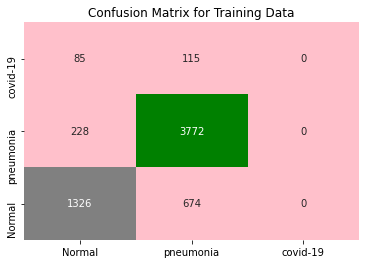

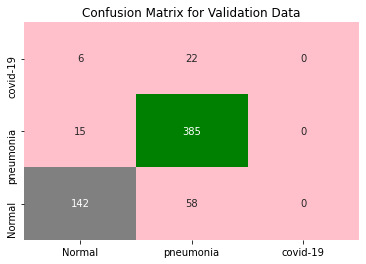

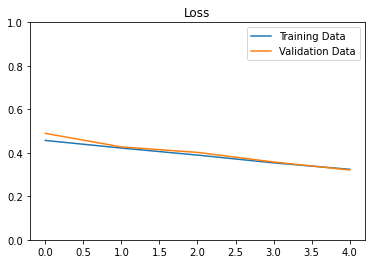

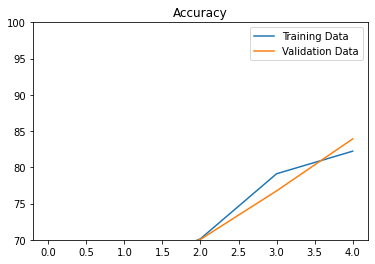

In [15]:
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)
filename = 'resnet18_Assignment5B.pth'
train_model(res18, Epochs,trainloader, validationloader, optimizer, criterion, filename)

In [17]:
testloader = torch.utils.data.DataLoader(test_data)
GenerateCSV(testloader,res18)

[]


1